## Семинар 2 "Распознавание рукописных цифр"

ФИО: Шахвалиева Юлиана Сергеевна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

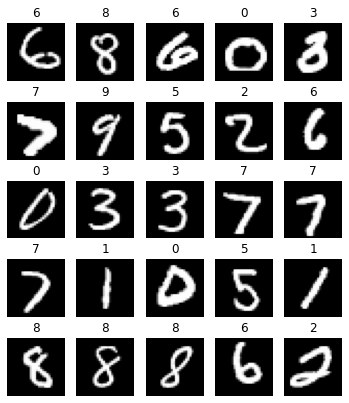

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, train_dataset=train_loader):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_dataset:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [13]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.306/0.299	Accuracy: 0.919/0.922

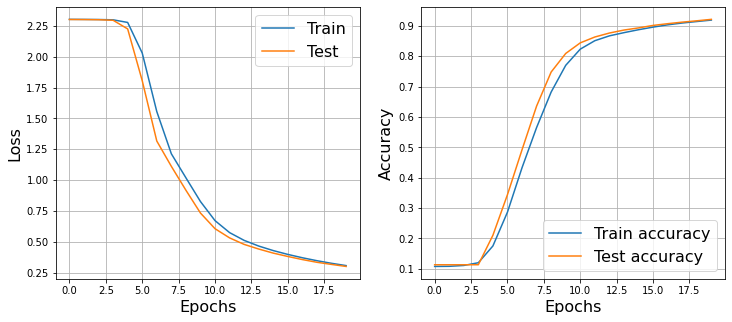

In [14]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

Полученная точность классификации на 20 эпохах с сигмоидой:

*   91,9% на обучающей выборке
*   92,2% на тестовой выборке




### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [6]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [7]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [17]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.037/0.080	Accuracy: 0.990/0.976

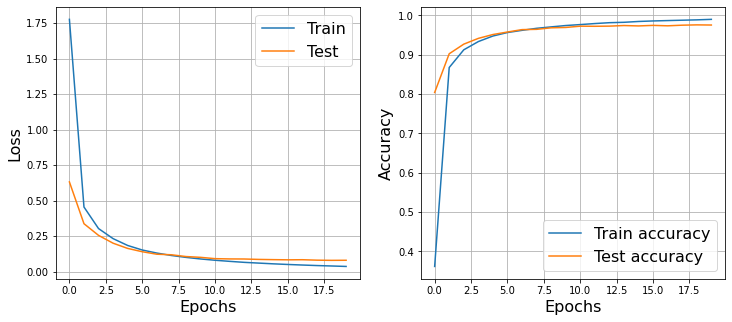

In [18]:
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Полученная точность классификации на 20 эпохах с ReLU:

*   99% на обучающей выборке
*   97,6% на тестовой выборке

Качество классификации возросло из-за использования в качестве функции активации ReLU. Можно заметить, что скорость сходимости также выросла, то есть модель обучилась быстрее, чем при использовании в качестве функции активации сигмоиды. 

In [19]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.046/0.086	Accuracy: 0.987/0.974

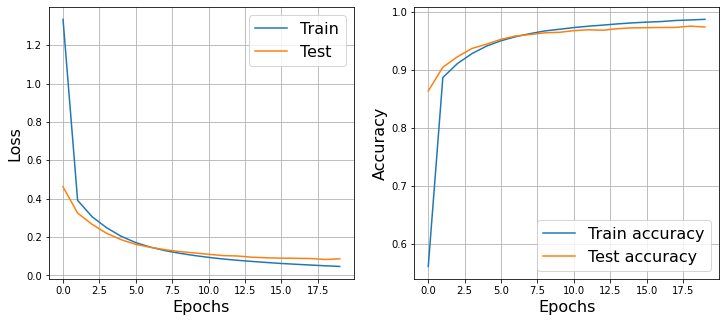

In [20]:
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Полученная точность классификации на 20 эпохах c ELU:

*   98,7% на обучающей выборке
*   97,4% на тестовой выборке

Эти показатели очень близки к тому, что получилось с использованием ReLU. 

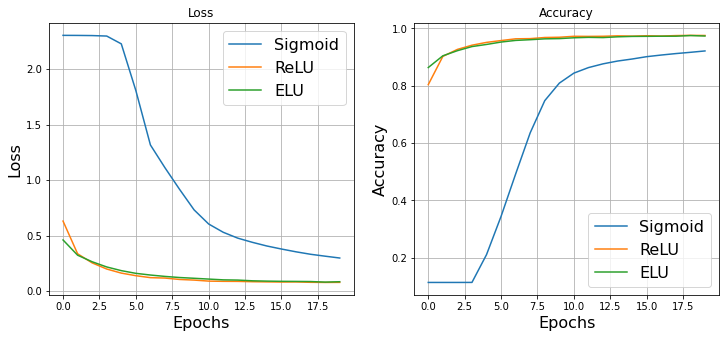

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Функции ReLU и ELU дали похожие результаты, отличие только на первой эпохе. Качество классификации также примерно равно. Существенно отличается от них сигмоида: ее скорость сходимости значительно ниже. На 20 эпохах сигмоиде не удалось достичь такого качества классификации, как предыдущим двум функциям.

### HW1 (1 балл): Реализовать Tanh

In [8]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.tanh = 2 / (1 + np.exp(-2 * X)) - 1
        return self.tanh

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return 1 - self.tanh ** 2

    def step(self, learning_rate):
        pass

### Часть 3: Анализ ошибок

In [24]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

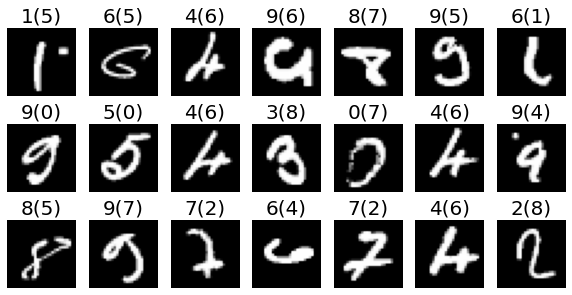

In [25]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [9]:
import random
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [10]:
def rotate_img(img):
    angle = random.randint(-15, 15)
    return rotate(img, angle=angle)

def shift_img(img):
    shear = round(random.uniform(-0.5, 0.5), 1)
    tf = AffineTransform(shear=shear)
    return warp(img, tf, order=1, preserve_range=True, mode='constant')

def noise_img(img):
    return random_noise(img, var=0.1**2)

def aug_dataset(transformation):
    XtrainAug, ytrainAug = [], []

    for X, y in train_loader:
      for i in range(X.shape[0]):
        XtrainAug.append(X[i].view(X[i].shape[1], -1).numpy())
        XtrainAug.append(transformation(X[i].view(X[i].shape[1], -1).numpy()))

        ytrainAug.append(y[i].numpy())
        ytrainAug.append(y[i].numpy())

    return np.array(XtrainAug), np.array(ytrainAug)

In [11]:
class AugTrainDataset(Dataset):
    def __init__(self, Xtrain, ytrain):
      self.images = Xtrain
      self.img_labels = ytrain
        
    def __len__(self):
        return self.img_labels.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.img_labels[idx]

## Небольшие вращения (-15, 15)
Удвоим датасет с помощью небольших вращений.

(120000, 28, 28) (120000,)


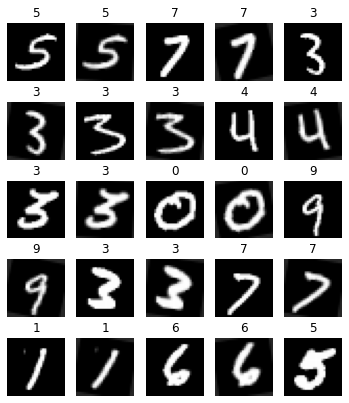

In [12]:
Xtrain_rotate, ytrain_rotate = aug_dataset(rotate_img)
print(Xtrain_rotate.shape, ytrain_rotate.shape)
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Xtrain_rotate[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(ytrain_rotate[i])
    plt.axis('off')
plt.show()

Обучим нейросеть на новом датасете с параметрами, которые были использованы ранее. В качестве функции активации будем использовать сигмоиду, чтобы увидеть, какой прирост даст аугментация. Так как другие функции активации показали очень высокие результаты и без аугментации (~98%), используя их, будет сложнее увидеть прирост.

In [13]:
train_rotate = DataLoader(AugTrainDataset(Xtrain_rotate, ytrain_rotate), batch_size=32, shuffle=True)

In [14]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.155/0.149	Accuracy: 0.957/0.959

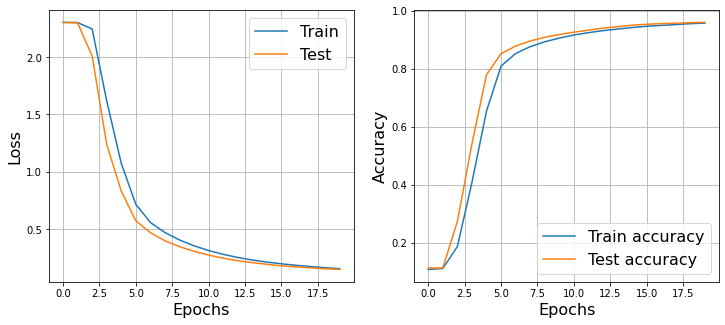

In [15]:
tr_rotate, ts_rotate, tr_ac_rotate, ts_ac_rotate = train(network, 20, 0.01, plot=True, verbose=True, train_dataset=train_rotate)

Полученная точность классификации на 20 эпохах с сигмоидой и вращениями:

*   95,7% на обучающей выборке
*   95,9% на тестовой выборке

Качество классификации при использовании аугментации выросло на ~4%, что является хорошим приростом. Также увеличилась скорость сходимости (кривая ошибок стала более крутая).

## Случайные сдвиги
Удвоим датасет с помощью случайных сдвигов.

(120000, 28, 28) (120000,)


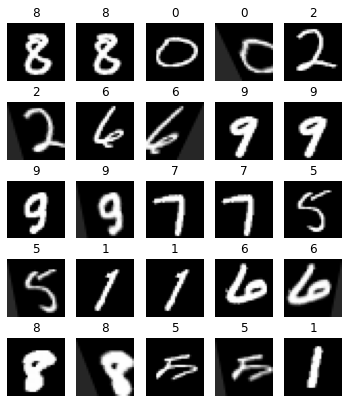

In [16]:
Xtrain_shift, ytrain_shift = aug_dataset(shift_img)
print(Xtrain_shift.shape, ytrain_shift.shape)
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Xtrain_shift[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(ytrain_shift[i])
    plt.axis('off')
plt.show()

Обучим нейросеть на новом датасете с параметрами, которые были использованы ранее. 

In [17]:
train_shift = DataLoader(AugTrainDataset(Xtrain_shift, ytrain_shift), batch_size=32, shuffle=True)

In [18]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.240/0.174	Accuracy: 0.933/0.952

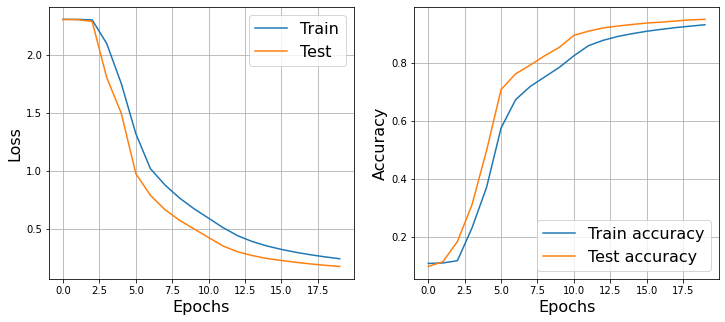

In [19]:
tr_shift, ts_shift, tr_ac_shift, ts_ac_shift = train(network, 20, 0.01, plot=True, verbose=True, train_dataset=train_shift)

Полученная точность классификации на 20 эпохах с сигмоидой и cлучайными сдвигами:

*   93,3% на обучающей выборке
*   95,2% на тестовой выборке

Качество классификации при использовании аугментации выросло на ~2.5%, что меньше, чем при использовании вращений. Скорость сходимости немного выросла по сравнению с моделью, обученной на фактических данных.

## Шум
Удвоим датасет с помощью случайного шума.

(120000, 28, 28) (120000,)


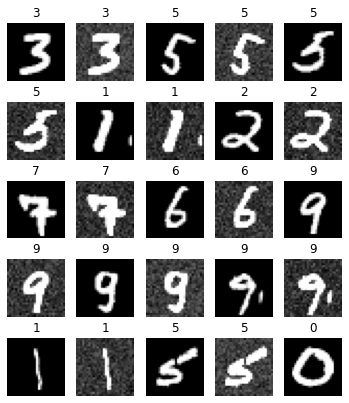

In [20]:
Xtrain_noise, ytrain_noise = aug_dataset(noise_img)
print(Xtrain_noise.shape, ytrain_noise.shape)
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Xtrain_noise[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(ytrain_noise[i])
    plt.axis('off')
plt.show()

Обучим нейросеть на новом датасете с параметрами, которые были использованы ранее. 

In [21]:
train_noise = DataLoader(AugTrainDataset(Xtrain_noise, ytrain_noise), batch_size=32, shuffle=True)

In [22]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.190/0.177	Accuracy: 0.948/0.951

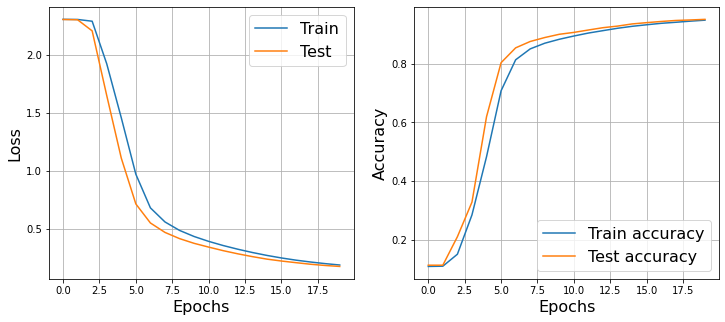

In [23]:
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train(network, 20, 0.01, plot=True, verbose=True, train_dataset=train_noise)

Полученная точность классификации на 20 эпохах с сигмоидой и cлучайным шумом:

*   94,8% на обучающей выборке
*   95,1% на тестовой выборке

Качество классификации при использовании аугментации выросло на ~2.5%, что меньше, чем при использовании вращений. Скорость сходимости немного выросла по сравнению с моделью, обученной на фактических данных.

## Объединение аугментаций

(240000, 28, 28) (240000,)


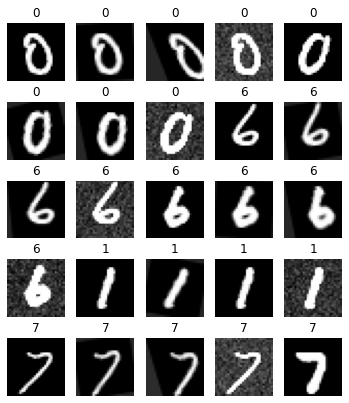

In [24]:
Xtrain_all_aug, ytrain_all_aug = [], []

for X, y in train_loader:
  for i in range(X.shape[0]):
    Xtrain_all_aug.append(X[i].view(X[i].shape[1], -1).numpy())
    Xtrain_all_aug.append(rotate_img(X[i].view(X[i].shape[1], -1).numpy()))
    Xtrain_all_aug.append(shift_img(X[i].view(X[i].shape[1], -1).numpy()))
    Xtrain_all_aug.append(noise_img(X[i].view(X[i].shape[1], -1).numpy()))

    for _ in range(4):
      ytrain_all_aug.append(y[i].numpy())

Xtrain_all_aug = np.array(Xtrain_all_aug)
ytrain_all_aug = np.array(ytrain_all_aug)

print(Xtrain_all_aug.shape, ytrain_all_aug.shape)

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(Xtrain_all_aug[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(ytrain_all_aug[i])
    plt.axis('off')
plt.show()

In [25]:
train_all_aug = DataLoader(AugTrainDataset(Xtrain_all_aug, ytrain_all_aug), batch_size=32, shuffle=True)

In [26]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.121/0.089	Accuracy: 0.966/0.974

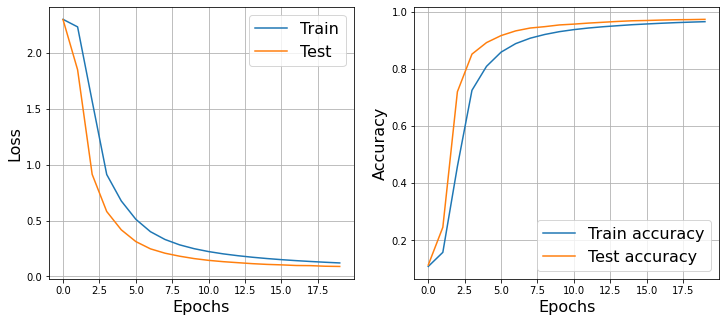

In [27]:
tr_all_aug, ts_all_aug, tr_ac_all_aug, ts_ac_all_aug = train(network, 20, 0.01, plot=True, verbose=True, train_dataset=train_all_aug)

Полученная точность классификации на 20 эпохах с сигмоидой и тремя аугментациями:

*   96,6% на обучающей выборке
*   97,4% на тестовой выборке

Качество классификации при использовании трех преобразований одновременно сильно выросло по сравнению с моделью, обученной на фактических данных. Скорость сходимости значительно выросла по сравнению как с моделью, обученной на фактических данных, так и с моделями, обученными на данных, преобразованных только одним способом.

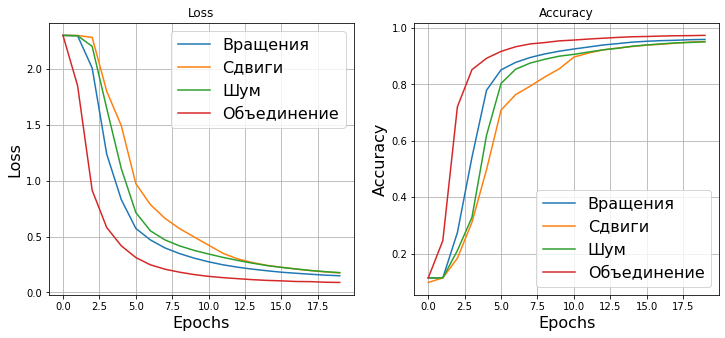

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rotate, label='Вращения')
plt.plot(ts_shift, label='Сдвиги')
plt.plot(ts_noise, label='Шум')
plt.plot(ts_all_aug, label='Объединение')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rotate, label='Вращения')
plt.plot(ts_ac_shift, label='Сдвиги')
plt.plot(ts_ac_noise, label='Шум')
plt.plot(ts_ac_all_aug, label='Объединение')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Из графика видно, что использование всех трех типов аугментации дало самый лучший результат: как в качестве классификации, так и в скорости сходимости. Случайные вращения и шум дали похожие результаты в скорости сходимости. Модель со случайными сдвигами обучалась медленнее, но в итоге пришла к такому же результату, как и случайный шум.

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Для изучения влияния нелинейности в работе были построены несколько идентичных моделей с разными функциями активации для понимания влияния последних на итоговые результаты. В работе были протестированы три функции активации: сигмоида, ReLU и ELU. Сигмоида показала самый низкий результат, ReLU и ELU показали практически одинаковое качество классификации, близкое к 100%. 

Далее было изучено влияние предобработки данных на качество итогового предсказания. Для сравнения разных типов аугментации были построенны модели с одинаковыми параметрами на разных входных данных. В качестве функции активации была выбрана сигмоида, так как она показала самое низкое качество классификации в сравнении с другими функциями активации. Использование сигмоиды позволяет проще оценить влияние аугментации на качество классификации, так как остальные функции активации показали высокие результаты и без предобработки данных. 

Было протестировано три типа аугментации: небольшие вращения (-15, 15), случайные сдвиги и шум. Для каждого типа был удвоен датасет: к начальным данным были добавлены аугментированные. Все три типа показали прирост качества классификации в сравнении с моделью, построенной на начальных данных. Лучше всего себя показали небольшие вращения. 

В конце была построена модель с одновременным использованием трех вышеперечисленных типов аугментации: датасет был увеличен в 4 раза. Это преобразование значительно увеличило качество классификации, а также скорость сходимости.

Таким образом, изменение функции активации и предобработка данных оказывают сильное влияние как на итоговое качество классификации, так и на скорость сходимости. 